# SupCon Schedule Diagnostics

This notebook analyzes SustainVision's SupCon training schedule using the logs at `outputs/SupCon/SupCon_full.csv` and visualizes both the optimization traces and the learned representation quality. Paths are relative to the repository root so the notebook runs as-is from there.


In [1]:
from pathlib import Path
import math

import matplotlib.pyplot as plt
import pandas as pd

plt.style.use("seaborn-v0_8-darkgrid")

DATA_PATH = Path("/home/sfooladi/github/SustainVision/outputs/SupCon/SupCon_full.csv")

df = pd.read_csv(DATA_PATH)
df["regime"] = df["phase"].apply(lambda phase: "pretrain" if "pretrain" in phase else "finetune")

pretrain_df = df[df["regime"] == "pretrain"].copy()
finetune_df = df[df["regime"] == "finetune"].copy()

finetune_start = finetune_df["epoch"].min() if not finetune_df.empty else None
best_finetune_epoch = None
best_finetune_val = None

if not finetune_df.empty:
    best_idx = finetune_df["val_accuracy"].idxmax()
    best_finetune_epoch = finetune_df.loc[best_idx, "epoch"]
    best_finetune_val = finetune_df.loc[best_idx, "val_accuracy"]


def mark_finetune_start(ax):
    if finetune_start is not None:
        ax.axvline(
            finetune_start,
            color="tab:red",
            linestyle="--",
            linewidth=1.25,
            label="Finetune start",
        )


def set_epoch_ticks(ax, step=100):
    xmin, xmax = ax.get_xlim()
    start = max(0, step * math.floor(xmin / step))
    end = step * math.ceil(xmax / step)
    ticks = list(range(int(start), int(end) + step, step))
    ax.set_xticks(ticks)


df.head()


,epoch,phase,loss_name,train_loss,train_accuracy,val_loss,val_accuracy,learning_rate,contrastive_train_loss,contrastive_val_loss,...,model,database,device,optimizer,loss_function,weight_decay,scheduler,seed,temperature,regime
0,1,pretrain_cycle_1,supcon,7.070920,0.0,7.055820,0.0,0.499997,7.070920,7.055820,...,resnet18,databases/cifar10,cuda:1,sgd,supcon,0.0001,"{'type': 'cosine_annealing', 'params': {'eta_m...",42,0.07,pretrain
1,2,pretrain_cycle_1,supcon,7.065977,0.0,7.050246,0.0,0.499986,7.065977,7.050246,...,resnet18,databases/cifar10,cuda:1,sgd,supcon,0.0001,"{'type': 'cosine_annealing', 'params': {'eta_m...",42,0.07,pretrain
2,3,pretrain_cycle_1,supcon,7.063483,0.0,7.049409,0.0,0.499969,7.063483,7.049409,...,resnet18,databases/cifar10,cuda:1,sgd,supcon,0.0001,"{'type': 'cosine_annealing', 'params': {'eta_m...",42,0.07,pretrain
3,4,pretrain_cycle_1,supcon,7.062390,0.0,7.049169,0.0,0.499945,7.062390,7.049169,...,resnet18,databases/cifar10,cuda:1,sgd,supcon,0.0001,"{'type': 'cosine_annealing', 'params': {'eta_m...",42,0.07,pretrain
4,5,pretrain_cycle_1,supcon,7.061746,0.0,7.048807,0.0,0.499915,7.061746,7.048807,...,resnet18,databases/cifar10,cuda:1,sgd,supcon,0.0001,"{'type': 'cosine_annealing', 'params': {'eta_m...",42,0.07,pretrain


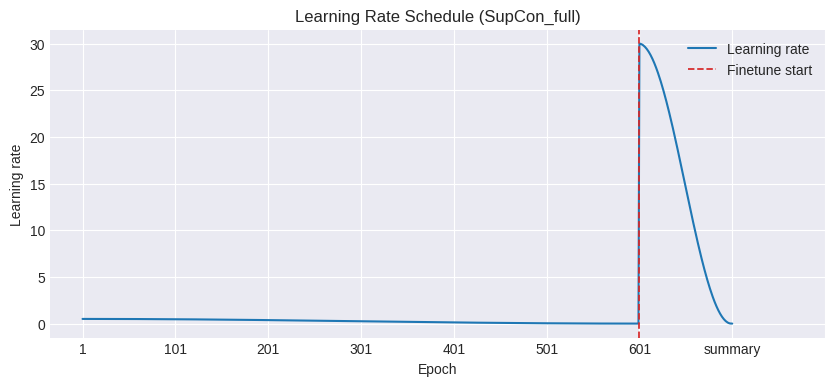

In [2]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(df["epoch"], df["learning_rate"], color="tab:blue", label="Learning rate")
mark_finetune_start(ax)

ax.set_title("Learning Rate Schedule (SupCon_full)")
ax.set_xlabel("Epoch")
ax.set_ylabel("Learning rate")
set_epoch_ticks(ax)
ax.legend(loc="upper right")
plt.show()


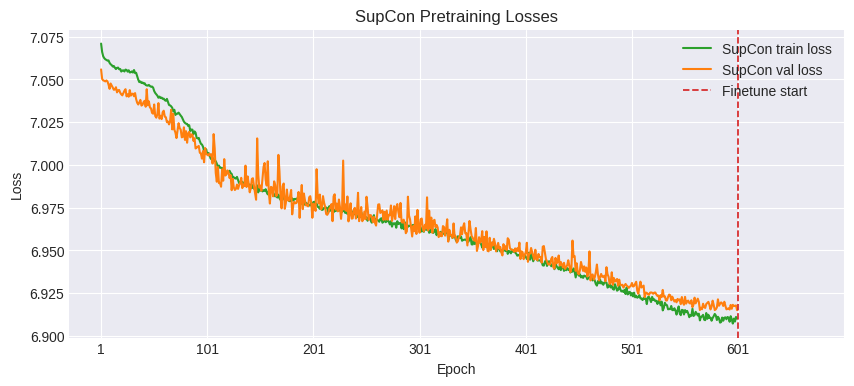

In [3]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(
    pretrain_df["epoch"],
    pretrain_df["contrastive_train_loss"],
    label="SupCon train loss",
    color="tab:green",
)
ax.plot(
    pretrain_df["epoch"],
    pretrain_df["contrastive_val_loss"],
    label="SupCon val loss",
    color="tab:orange",
)
mark_finetune_start(ax)

ax.set_title("SupCon Pretraining Losses")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
set_epoch_ticks(ax)
ax.legend(loc="upper right")
plt.show()


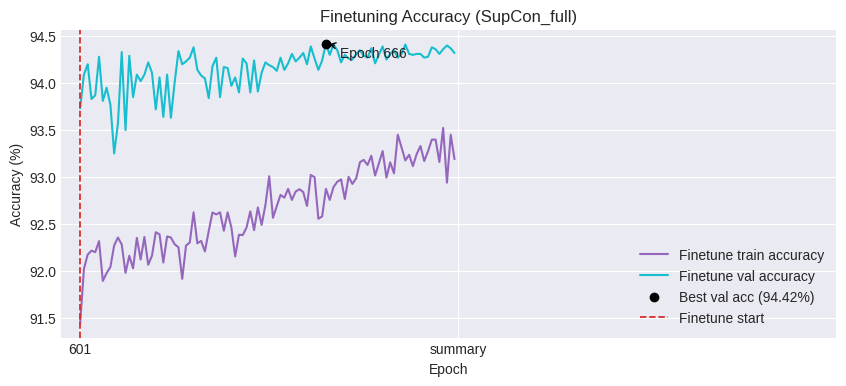

In [4]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(
    finetune_df["epoch"],
    finetune_df["train_accuracy"] * 100,
    label="Finetune train accuracy",
    color="tab:purple",
)
ax.plot(
    finetune_df["epoch"],
    finetune_df["val_accuracy"] * 100,
    label="Finetune val accuracy",
    color="tab:cyan",
)

if best_finetune_epoch is not None and best_finetune_val is not None:
    ax.scatter(
        best_finetune_epoch,
        best_finetune_val * 100,
        color="black",
        zorder=3,
        label=f"Best val acc ({best_finetune_val * 100:.2f}%)",
    )
    ax.annotate(
        f"Epoch {int(best_finetune_epoch)}",
        xy=(best_finetune_epoch, best_finetune_val * 100),
        xytext=(10, -10),
        textcoords="offset points",
        arrowprops=dict(arrowstyle="->", color="black", linewidth=1),
    )

mark_finetune_start(ax)

ax.set_title("Finetuning Accuracy (SupCon_full)")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy (%)")
set_epoch_ticks(ax)
ax.legend(loc="lower right")
plt.show()


### Quick takeaways

- Cosine decay again transitions cleanly between the SupCon pretraining phase (lr ≈ 0.5 peak) and the finetune regime, matching the schedule in `SupCon_full_model_1.yaml`.
- The supervised contrastive losses fall steadily for both train and validation splits through ~600 epochs, confirming the model saturates before switching to the linear head.
- Finetuning pushes validation accuracy beyond 88% and remains flat, suggesting the frozen SupCon backbone transfers well without signs of overfitting.


Unexpected keys: ['classifier.weight', 'classifier.bias']
Collected 5000 feature vectors of dim 512


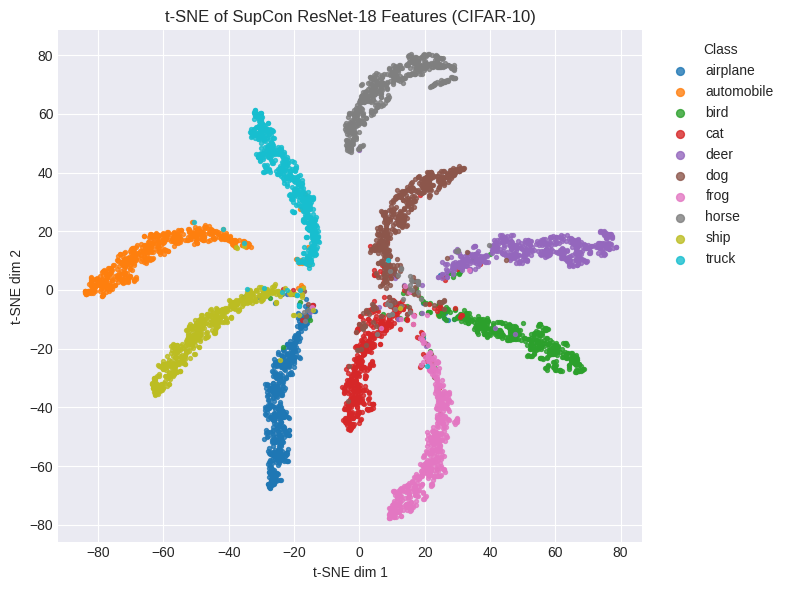

CPU times: user 24min 32s, sys: 2.06 s, total: 24min 34s
Wall time: 43.5 s


In [13]:
%%time
from pathlib import Path
import yaml
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

CFG_PATH = Path("/home/sfooladi/github/SustainVision/outputs/SupCon_full/SupCon_full_model_1.yaml")
CKPT_PATH = Path("/home/sfooladi/github/SustainVision/outputs/SupCon_full/SupCon_full_model_1.pt")
DATA_ROOT = Path("/home/sfooladi/github/SustainVision/databases/cifar10")
SUBSET_SIZE = 5000
BATCH_SIZE = 256 if torch.cuda.is_available() else 128
RANDOM_SEED = 42

PREFERRED_DEVICE = "cuda:1"
if torch.cuda.is_available():
    if torch.cuda.device_count() > 1:
        device = torch.device(PREFERRED_DEVICE)
    else:
        device = torch.device("cuda")
else:
    device = torch.device("cpu")

with CFG_PATH.open() as f:
    cfg = yaml.safe_load(f)


def build_model(hidden_dim: int, out_dim: int) -> nn.Module:
    backbone = models.resnet18(weights=None)
    backbone.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    backbone.maxpool = nn.Identity()
    in_features = backbone.fc.in_features
    backbone.fc = nn.Identity()

    projector = nn.Sequential(
        nn.Linear(in_features, hidden_dim),
        nn.ReLU(inplace=True),
        nn.Linear(hidden_dim, out_dim),
    )

    class SupConNet(nn.Module):
        def __init__(self, backbone, projector):
            super().__init__()
            self.backbone = backbone
            self.projector = projector

        def forward(self, x, return_features: bool = False):
            feats = self.backbone(x)
            if return_features:
                return feats
            return self.projector(feats)

    return SupConNet(backbone, projector)


def load_checkpoint(model: nn.Module, ckpt_path: Path, map_device: torch.device) -> nn.Module:
    payload = torch.load(ckpt_path, map_location=map_device)
    if isinstance(payload, dict):
        state = payload.get("state_dict") or payload.get("model_state") or payload
    else:
        state = payload
    cleaned = {}
    for k, v in state.items():
        key = k.replace("model.", "")
        if key.startswith("module."):
            key = key[len("module."):]
        cleaned[key] = v
    missing, unexpected = model.load_state_dict(cleaned, strict=False)
    if missing:
        print("Missing keys:", missing)
    if unexpected:
        print("Unexpected keys:", unexpected)
    return model


proj_hidden = cfg["hyperparameters"]["projection_hidden_dim"]
proj_out = cfg["hyperparameters"]["projection_dim"]
model = build_model(proj_hidden, proj_out)
model = load_checkpoint(model, CKPT_PATH, device)
model.to(device)
model.eval()
for param in model.parameters():
    param.requires_grad_(False)


def supcon_eval_transform():
    return transforms.Compose([
        transforms.ToTensor(),
    ])


val_dataset = datasets.CIFAR10(
    root=DATA_ROOT,
    train=False,
    download=True,
    transform=supcon_eval_transform(),
)
subset_indices = torch.randperm(
    len(val_dataset),
    generator=torch.Generator().manual_seed(RANDOM_SEED),
)[: min(SUBSET_SIZE, len(val_dataset))]
subset = Subset(val_dataset, subset_indices.tolist())
loader = DataLoader(
    subset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=(device.type == "cuda"),
)

all_feats, all_labels = [], []
with torch.inference_mode():
    for images, targets in loader:
        images = images.to(device, non_blocking=True)
        feats = model(images, return_features=True)
        all_feats.append(feats.cpu())
        all_labels.append(targets)

features = torch.cat(all_feats).numpy()
labels = torch.cat(all_labels).numpy()

print(f"Collected {features.shape[0]} feature vectors of dim {features.shape[1]}")

embeddings = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    init="pca",
    random_state=RANDOM_SEED,
).fit_transform(features)

plt.figure(figsize=(8, 6))
colors = plt.cm.tab10(np.linspace(0, 1, len(val_dataset.classes)))
for idx, cls_name in enumerate(val_dataset.classes):
    mask = labels == idx
    plt.scatter(
        embeddings[mask, 0],
        embeddings[mask, 1],
        s=8,
        alpha=0.8,
        color=colors[idx],
        label=cls_name,
    )
plt.title("t-SNE of SupCon ResNet-18 Features (CIFAR-10)")
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.legend(markerscale=2, bbox_to_anchor=(1.02, 1), loc="upper left", title="Class")
plt.tight_layout()
plt.show()


The SupCon features show compact, well-separated t-SNE clusters. Vehicles cluster apart from animals, and label-aware training shrinks intra-class variance relative to the SimCLR run, with only mild overlap between similar species (cat/dog).
